## **Pacotes**

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import os

## **Pré Processamento dos Dados**

In [3]:
# CARREGANDO OS DADOS
df = pd.read_csv(os.getcwd() + '\\data\\seoul_bike_data.csv', sep = ',', encoding = 'unicode_escape')

# TRADUZINDO O NOME DAS COLUNAS
df.columns = [
    'data',
    'qtde_bicicletas_alugadas',
    'hora',
    'temperatura',
    'umidade',
    'velocidade_do_vento',
    'visibilidade',
    'temperatura_ponto_de_orvalho',
    'radiacao_solar',
    'volume_de_chuva',
    'volume_de_neve',
    'estacao_do_ano',
    'feriado',
    'dia_util'
]

# TRANSFORMANDO OS DADOS DE DATA EM DATETIME
df['data'] = pd.to_datetime(df['data'], format = '%d/%m/%Y')

# CRIANDO UMA COLUNA SÓ COM O MÊS E O ANO
df['ano_e_mes'] = df['data'].apply(lambda data: datetime(year = data.year, month = data.month, day = 1))

# CRIANDO UMA COLUNA COM A DATA INCLUINDO A HORA
df['data_com_hora'] = np.nan
lista_data_com_hora = []
for i in df.index:
    ano = df.loc[i, 'data'].year
    mes = df.loc[i, 'data'].month
    dia = df.loc[i, 'data'].day
    hora = df.loc[i, 'hora']
    lista_data_com_hora.append(datetime(ano, mes, dia, hora))
df['data_com_hora'] = lista_data_com_hora

# CRIANDO UMA COLUNA COM O DIA DA SEMANA
df['dia_da_semana'] = df['data'].apply(lambda data: data.weekday())

# TRANSFORMANDO OS DIAS DA SEMANA DE NÚMERO PARA NOME
dicionario_dia_semana = {
    0: 'segunda',
    1: 'terça',
    2: 'quarta',
    3: 'quinta',
    4: 'sexta',
    5: 'sabado',
    6: 'domingo'
}
df['dia_da_semana'] = df['dia_da_semana'].map(dicionario_dia_semana)

# TRADUZINDO O NOME DAS ESTAÇÕES DO ANO PARA PORTUGUÊS
dicionario_estacao_do_ano = {
    'Summer': 'verao',
    'Spring': 'primavera',
    'Autumn': 'outono',
    'Winter': 'inverno'
}
df['estacao_do_ano'] = df['estacao_do_ano'].map(dicionario_estacao_do_ano)

# TRADUZINDO OS VALORES DA COLUNA FERIADO
df['feriado'] = df['feriado'].apply(lambda feriado: 'sim' if feriado == 'Holiday' else 'nao')

# TRADUZINDO OS VALORES DA COLUNA DIA UTIL
df['dia_util'] = df['dia_util'].apply(lambda dia_util: 'sim' if dia_util == 'Yes' else 'nao')

# CRIANDO UMA LISTA COM AS VARIÁVEIS NUMERICAS E REMOVENDO VARIÁVEIS QUE NÃO SÃO NECESSÁRIAS
variaveis_numericas = df.select_dtypes(include = ['int', 'float']).columns.to_list()
variaveis_numericas = [nome_coluna for nome_coluna in variaveis_numericas if nome_coluna not in ['hora']]

# CRIANDO UMA LISTA COM AS VARIÁVEIS CATEGÓRICAS
variaves_categoricas = df.select_dtypes(include = ['object']).columns.to_list()

## **Criando o Modelo**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X = df[variaveis_numericas + variaves_categoricas]
y = df['qtde_bicicletas_alugadas']

# CRIANDO E CONFIGURANDO UM TRANSFORMADOR DOS DADOS PARA O PIPELINE
transformador = ColumnTransformer(
    transformers = [
        ('cat_one_hot', OneHotEncoder(sparse_output = False), variaves_categoricas),
        ('num_padronizacao', StandardScaler(), variaveis_numericas)
    ],
    remainder = 'passthrough'
)

# CRIANDO E CONFIGURANDO O PIPELINE
pipeline = Pipeline(
    steps = [
        ('pre_processamento', transformador),
        ('modelo', RandomForestRegressor(random_state = 42))
    ]
)

pontuacao_validacao_cruzada = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print(f'Média de R2: {pontuacao_validacao_cruzada.mean()}')


Média de R2: 0.999935719463626


Com a validação cruzada, temos um overfitting. Faremos uma validação independente, com dados nunca vistos.

In [17]:
# HOLDOUT, DIVIDINDO OS DADOS EM TREINO E TESTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# TREINA COM OS DADOS DE TREINO
pipeline.fit(X_train, y_train)

# FAZ AS PREVISÕES COM OS DADOS DE TESTE
previsoes = pipeline.predict(X_test)

# AVALIACAO DO MODELO
from sklearn.metrics import mean_squared_error, mean_absolute_error

print(f"""
MSE: {mean_squared_error(previsoes, y_test)}
MAE: {mean_absolute_error(previsoes, y_test)}
      """)


MSE: 14.931539764079124
MAE: 0.39198249619482173
      


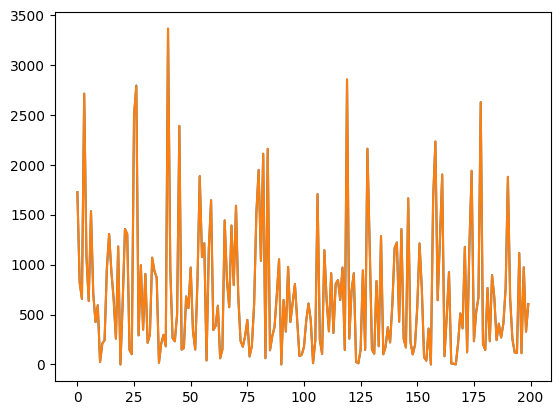

6056    1728
5556     822
5990     658
7674    2716
3319    1083
        ... 
6006     614
8063     806
14       447
5306      84
8524      97
Name: qtde_bicicletas_alugadas, Length: 100, dtype: int64
[1727.97  821.09  657.94 2714.8  1083.07  635.93 1536.07  711.56  424.94
  594.08   23.97  211.01  241.99  959.67 1308.62  932.75  655.03  259.01
 1183.02    0.    630.07 1357.54 1307.72  146.    102.94 2494.42 2791.79
  292.05  995.13  348.97  908.41  216.96  301.02 1070.97  936.89  870.49
   17.    209.    297.87  181.98 3368.44  956.21  264.    231.97  501.61
 2391.03  149.01  165.    682.41  564.97  971.97  337.83  150.01  842.01
 1888.34 1075.86 1215.83   40.02 1157.57 1646.51  345.    386.94  589.05
   61.99  150.01 1444.69  847.88  573.97 1393.6   795.87 1590.63  682.44
  237.    178.01  280.79  446.81   79.98  185.    604.13 1524.94 1948.47
 1038.78 2112.53   63.05 2162.19  142.02  283.01  376.13  698.1  1054.23
    0.    646.98  329.9   977.73  425.86  613.98  805.98  446.59   83

In [25]:
plt.plot([n for n in range(len(y_test))][:200], y_test[:200])
plt.plot([n for n in range(len(y_test))][:200], previsoes[:200])
plt.show()

print(y_test[:100])
print(previsoes[:100])